In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, KMeans, OPTICS, AgglomerativeClustering, Birch, MeanShift
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.spatial.distance import cdist

In [2]:
data = pd.read_csv('data/HW1_var_5.csv', delimiter=';')
data.drop('Номер варианта', axis=1, inplace=True)

In [3]:
# list categorical and numerical features
cats = ['INCOME_BASE_TYPE', 'CREDIT_PURPOSE', 'INSURANCE_FLAG', 'SEX', 'EDUCATION', 'EMPL_TYPE', 'EMPL_SIZE',
        'BANKACCOUNT_FLAG', 'EMPL_PROPERTY', 'EMPL_FORM', 'FAMILY_STATUS', 'if_zalog', 'dlq_exist', 'thirty_in_a_year',
        'sixty_in_a_year', 'ninety_in_a_year', 'thirty_vintage', 'sixty_vintage', 'ninety_vintage']
numerics = ['DTI', 'FULL_AGE_CHILD_NUMBER', 'DEPENDANT_NUMBER', 'Period_at_work', 'age', 'max14days', 'max21days', 'max30days',
            'max60days', 'max90days', 'avg_num_delay', 'num_AccountActive60', 'num_AccountActive90', 'num_AccountActive180',
            'Active_to_All_prc', 'numAccountActiveAll', 'numAccountClosed', 'sum_of_paym_months', 'all_credits', 'Active_not_cc',
            'own_closed', 'min_MnthAfterLoan', 'max_MnthAfterLoan']

## Data description

In [4]:
data[numerics].describe().T

,count,mean,std,min,25%,50%,75%,max
DTI,10121.0,0.385248,0.135915,0.0,0.280000,0.400000,0.490000,0.6
FULL_AGE_CHILD_NUMBER,10243.0,0.554330,0.785071,0.0,0.000000,0.000000,1.000000,14.0
DEPENDANT_NUMBER,10243.0,0.003710,0.073851,0.0,0.000000,0.000000,0.000000,2.0
Period_at_work,7923.0,66.374479,67.465261,6.0,21.000000,45.000000,87.000000,966.0
age,7923.0,36.324751,8.612645,23.0,29.000000,35.000000,43.000000,62.0
max14days,3921.0,0.523591,1.036584,0.0,0.000000,0.000000,1.000000,15.0
max21days,3921.0,0.635297,1.158869,0.0,0.000000,0.000000,1.000000,15.0
max30days,3921.0,0.850548,1.328305,0.0,0.000000,0.000000,1.000000,15.0
max60days,3921.0,1.140780,1.593697,0.0,0.000000,1.000000,2.000000,18.0
max90days,3921.0,1.585820,1.878678,0.0,0.000000,1.000000,2.000000,18.0


## Missing values

In [5]:
# calculate number and share of unique values in feature
def calc_unique(df: pd.DataFrame) -> tuple:
    uniq_percentage = []
    uniq_vals = []
    all_vals = len(df)
    for column in df.columns:
        uniq = pd.unique(df[column]).tolist()
        uniq_vals.append(len(uniq))
        uniq_percentage.append(
            len(uniq) / (all_vals - df[column].isna().sum()))

    return uniq_vals, uniq_percentage

# calcualate number and share of null values


def calc_null(df: pd.DataFrame) -> tuple:
    return df.isna().sum(), df.isna().sum() / (data.count() + data.isna().sum())

# calcualate number and share of zero values


def calc_zeros(df: pd.DataFrame) -> tuple:
    return df.eq(0).sum(), data.eq(0).sum() / data.count()

In [6]:
uniq_vals, uniq_percentage = calc_unique(data)
null_vals, null_percentage = calc_null(data)
zero_vals, zero_percentage = calc_zeros(data)

In [7]:
pd.DataFrame(np.array([uniq_vals, uniq_percentage, null_vals, null_percentage, zero_vals, zero_percentage]).T,
             columns=['num_of_unqiue', 'unique_percenage', 'num_of_null',
                      'null_percentage', 'num_of_zero', 'zero_percentage'], index=data.isna().sum().index)

,num_of_unqiue,unique_percenage,num_of_null,null_percentage,num_of_zero,zero_percentage
ID,10243.0,1.000000,0.0,0.000000,0.0,0.000000
INCOME_BASE_TYPE,5.0,0.000491,57.0,0.005565,0.0,0.000000
CREDIT_PURPOSE,10.0,0.000976,0.0,0.000000,0.0,0.000000
INSURANCE_FLAG,2.0,0.000195,0.0,0.000000,4104.0,0.400664
DTI,62.0,0.006126,122.0,0.011911,1.0,0.000099
SEX,2.0,0.000195,0.0,0.000000,0.0,0.000000
FULL_AGE_CHILD_NUMBER,7.0,0.000683,0.0,0.000000,6154.0,0.600801
DEPENDANT_NUMBER,3.0,0.000293,0.0,0.000000,10214.0,0.997169
EDUCATION,9.0,0.000879,0.0,0.000000,0.0,0.000000
EMPL_TYPE,10.0,0.000977,9.0,0.000879,0.0,0.000000


In [8]:
# remove null values, these
new_data = data[data.all_credits.isna() == False]

In [9]:
uniqs, uniq_perc = calc_unique(new_data)
nulls, null_perc = calc_null(new_data)
zeros, zero_perc = calc_zeros(new_data)

In [10]:
pd.DataFrame(np.array([uniqs, uniq_perc, nulls, null_perc, zeros, zero_perc]).T,
             columns=['num_of_unqiue', 'unique_percenage', 'num_of_null',
                      'null_percentage', 'num_of_zero', 'zero_percentage'], index=data.isna().sum().index)

,num_of_unqiue,unique_percenage,num_of_null,null_percentage,num_of_zero,zero_percentage
ID,3676.0,1.000000,0.0,0.000000,0.0,0.000000
INCOME_BASE_TYPE,4.0,0.001088,0.0,0.000000,0.0,0.000000
CREDIT_PURPOSE,10.0,0.002720,0.0,0.000000,0.0,0.000000
INSURANCE_FLAG,2.0,0.000544,0.0,0.000000,1430.0,0.400664
DTI,59.0,0.016050,0.0,0.000000,0.0,0.000099
SEX,2.0,0.000544,0.0,0.000000,0.0,0.000000
FULL_AGE_CHILD_NUMBER,7.0,0.001904,0.0,0.000000,2261.0,0.600801
DEPENDANT_NUMBER,3.0,0.000816,0.0,0.000000,3667.0,0.997169
EDUCATION,8.0,0.002176,0.0,0.000000,0.0,0.000000
EMPL_TYPE,9.0,0.002448,0.0,0.000000,0.0,0.000000


In [11]:
# find incorrect ones
pd.DataFrame(new_data.eq('*n.a.*').sum(), columns=['num_of_*n.a.*'])

,num_of_*n.a.*
ID,0
INCOME_BASE_TYPE,0
CREDIT_PURPOSE,0
INSURANCE_FLAG,0
DTI,0
SEX,0
FULL_AGE_CHILD_NUMBER,0
DEPENDANT_NUMBER,0
EDUCATION,16
EMPL_TYPE,0


In [12]:
new_data.drop(new_data[(new_data['EDUCATION'] == '*n.a.*') | (new_data['EMPL_SIZE']
              == '*n.a.*')].index, inplace=True)  # remove incorrect values

/var/folders/1s/_mm_j5693hv5tyz456g5_g140000gn/T/ipykernel_31909/2634256998.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data.drop(new_data[(new_data['EDUCATION'] == '*n.a.*') | (new_data['EMPL_SIZE']


In [13]:
# see remaining nulls
new_data.isna().sum()

ID                        0
INCOME_BASE_TYPE          0
CREDIT_PURPOSE            0
INSURANCE_FLAG            0
DTI                       0
SEX                       0
FULL_AGE_CHILD_NUMBER     0
DEPENDANT_NUMBER          0
EDUCATION                 0
EMPL_TYPE                 0
EMPL_SIZE                 0
BANKACCOUNT_FLAG          0
Period_at_work            0
age                       0
EMPL_PROPERTY             0
EMPL_FORM                 0
FAMILY_STATUS             0
max90days                 2
max60days                 2
max30days                 2
max21days                 2
max14days                 2
avg_num_delay            11
if_zalog                  0
num_AccountActive180      0
num_AccountActive90       0
num_AccountActive60       0
Active_to_All_prc         0
numAccountActiveAll       0
numAccountClosed          0
sum_of_paym_months        0
all_credits               0
Active_not_cc             0
own_closed                0
min_MnthAfterLoan         0
max_MnthAfterLoan   

## data imputation

In [14]:
# find mean values to impute
mean_vals = new_data[['max14days', 'max21days', 'max30days',
                      'max60days', 'max90days', 'avg_num_delay']].mean().tolist()

In [15]:
new_data.fillna(value={'max14days': mean_vals[0], 'max21days': mean_vals[1], 'max30days': mean_vals[2],
                       'max60days': mean_vals[3], 'max90days': mean_vals[4], 'avg_num_delay': mean_vals[5]}, inplace=True)

/var/folders/1s/_mm_j5693hv5tyz456g5_g140000gn/T/ipykernel_31909/2763375976.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data.fillna(value={'max14days': mean_vals[0], 'max21days': mean_vals[1], 'max30days': mean_vals[2],


In [16]:
new_data

,ID,INCOME_BASE_TYPE,CREDIT_PURPOSE,INSURANCE_FLAG,DTI,SEX,FULL_AGE_CHILD_NUMBER,DEPENDANT_NUMBER,EDUCATION,EMPL_TYPE,...,own_closed,min_MnthAfterLoan,max_MnthAfterLoan,dlq_exist,thirty_in_a_year,sixty_in_a_year,ninety_in_a_year,thirty_vintage,sixty_vintage,ninety_vintage
2,1000045,2НДФЛ,Ремонт,1,0.49,мужской,0,0,высшее,менеджер среднего звена,...,0.0,66.0,66.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1000085,Поступление зарплаты на счет,Ремонт,0,0.16,мужской,1,0,высшее,менеджер высшего звена,...,0.0,49.0,86.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1000105,Поступление зарплаты на счет,Ремонт,0,0.20,женский,0,0,Высшее/Второе высшее/Ученая степень,вспомогательный персонал,...,3.0,7.0,66.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1000125,Свободная форма с печатью работодателя,Покупка недвижимости/ строительство,1,0.49,женский,0,0,высшее,специалист,...,0.0,5.0,57.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
13,1000265,Форма банка (без печати работодателя),Ремонт,1,0.18,мужской,0,0,среднее-специальное,специалист,...,1.0,6.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10230,1204605,Свободная форма с печатью работодателя,Ремонт,1,0.31,женский,1,0,Высшее/Второе высшее/Ученая степень,специалист,...,0.0,13.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10232,1204645,Форма банка (без печати работодателя),Покупка недвижимости/ строительство,0,0.44,женский,1,0,высшее,вспомогательный персонал,...,3.0,12.0,69.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10235,1204705,Форма банка (без печати работодателя),Ремонт,1,0.25,женский,0,0,высшее,вспомогательный персонал,...,0.0,1.0,46.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
10239,1204785,Форма банка (без печати работодателя),Ремонт,1,0.31,мужской,0,0,Высшее/Второе высшее/Ученая степень,менеджер высшего звена,...,3.0,16.0,95.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
new_data.to_csv('new_new_data.csv')  # data to visualise in tableau

## Correlations

In [18]:
new_data.drop(['ID'], axis=1).corr().shape

/var/folders/1s/_mm_j5693hv5tyz456g5_g140000gn/T/ipykernel_31909/1571483999.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  new_data.drop(['ID'], axis=1).corr().shape


(33, 33)

<Axes: >

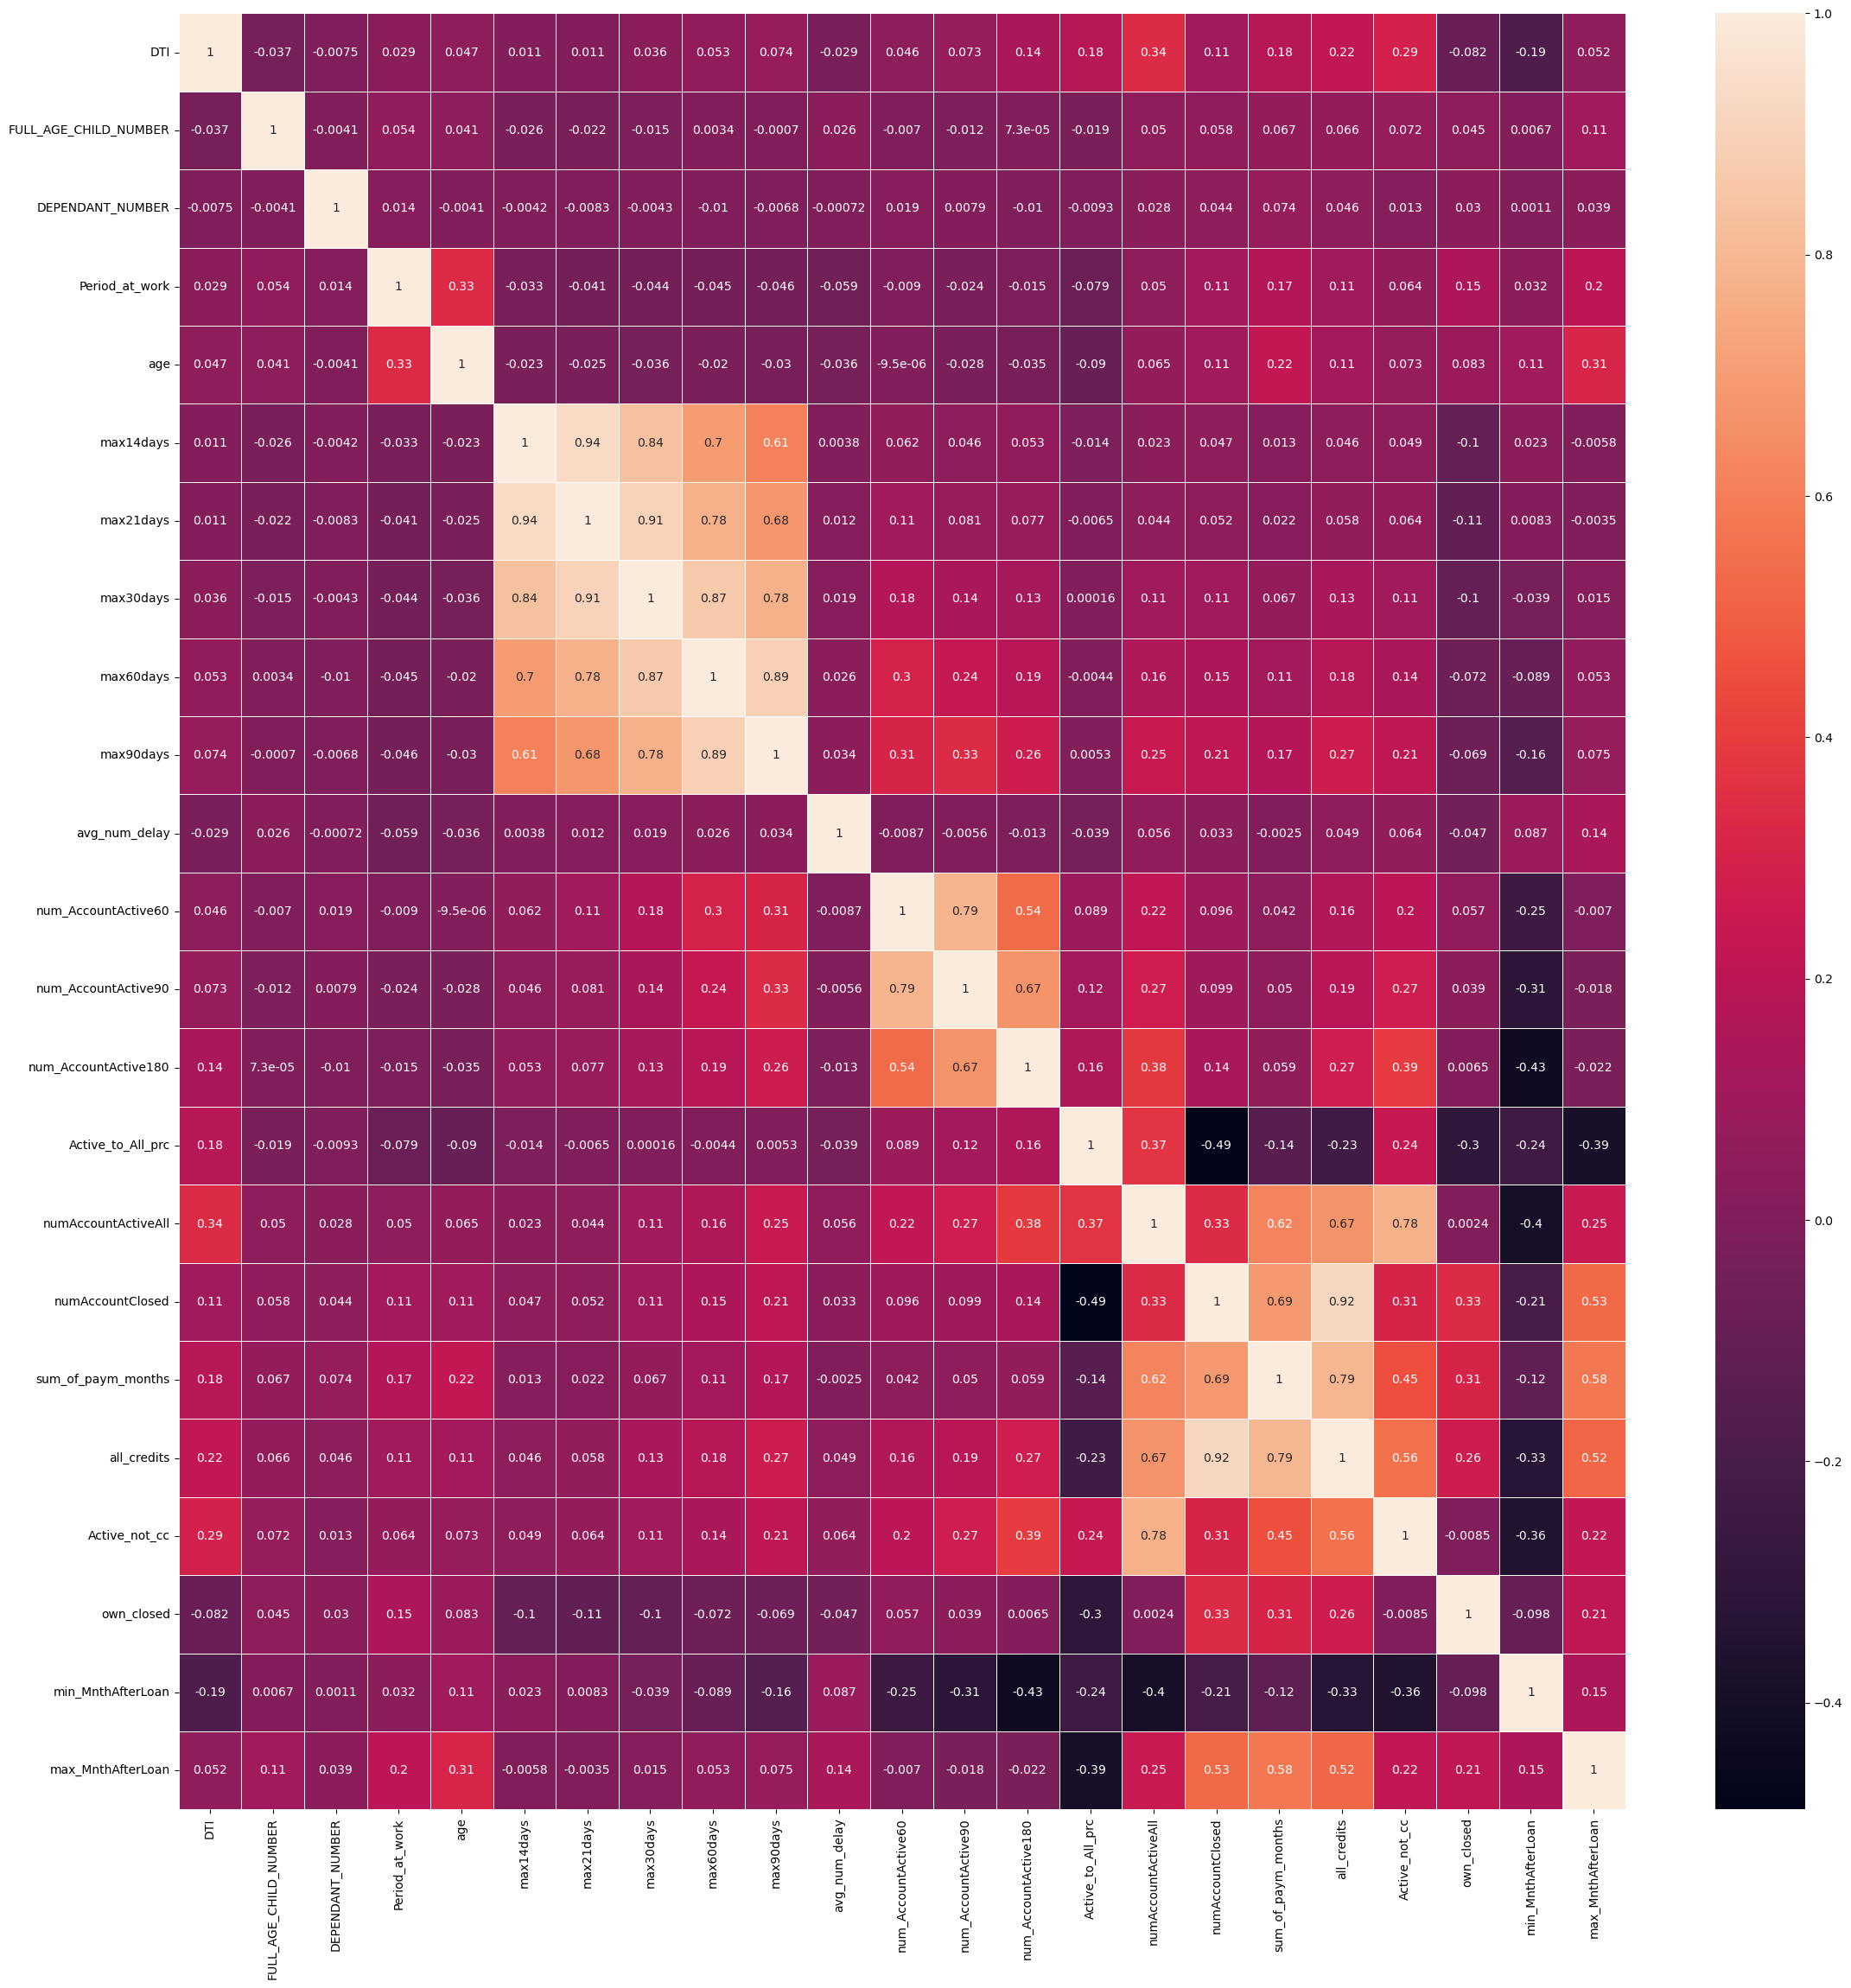

In [19]:
fig, ax = plt.subplots(figsize=(27, 27))         # Sample figsize in inches

sns.heatmap(new_data.drop(['ID'], axis=1)[numerics].corr(),
            annot=True, linewidths=.5, ax=ax)

## Encoding

In [20]:
# encode SEX feature
to_replace = {'мужской': 0, 'женский': 1}
new_data['SEX'].replace(to_replace=to_replace, inplace=True)

/var/folders/1s/_mm_j5693hv5tyz456g5_g140000gn/T/ipykernel_31909/2154999714.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['SEX'].replace(to_replace=to_replace, inplace=True)


In [21]:
# encode EDUCATION feature
to_replace = {"Неполное среднее": 1, "среднее": 2, "среднее-специальное": 3, "незаконченное высшее": 4,
              "высшее": 5, "второе высшее": 6, "ученая степень": 7, "Высшее/Второе высшее/Ученая степень": 6}
new_data['EDUCATION'].replace(to_replace=to_replace, inplace=True)

/var/folders/1s/_mm_j5693hv5tyz456g5_g140000gn/T/ipykernel_31909/1740142664.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['EDUCATION'].replace(to_replace=to_replace, inplace=True)


In [22]:
# now remove them to get One hot encoding for other ones
cats.remove('EDUCATION')
cats.remove('SEX')

In [23]:
cats_encoded = pd.get_dummies(new_data[cats])  # one hot encoding
cats_encoded['sex'] = new_data['SEX']
cats_encoded['education'] = new_data['EDUCATION']

In [24]:
new_data_encoded = pd.concat([new_data[numerics], cats_encoded], axis=1)

In [25]:
scaler = StandardScaler()
final = scaler.fit_transform(new_data_encoded)

In [26]:
final.shape

(3659, 77)

## Segmenatation

### reduce dimension

In [27]:
reduction_tsne = TSNE(n_components=2, perplexity=30)
reduced_tsne = reduction_tsne.fit_transform(final)

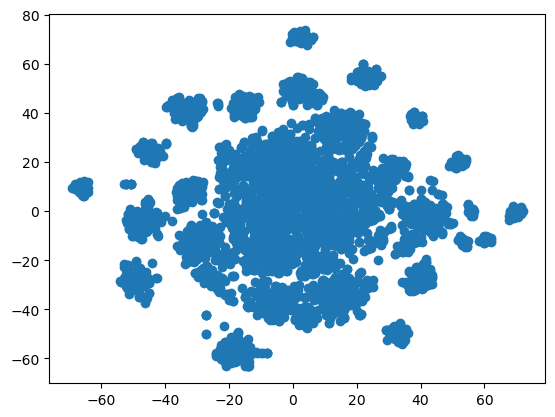

In [28]:
plt.scatter(x=reduced_tsne[:, 0], y=reduced_tsne[:, 1])

## make clustering

In [29]:
# plot results of clusterng
def plot_clusters(data, labels, title):
    unique_labels = set(labels)
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

    for label, color in zip(unique_labels, colors):
        cluster_points = data[labels == label]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1],
                    color=color, label=f'Cluster {label}')

    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    # plt.legend()
    plt.show()

### clustering by density estimation

In [30]:
# DBSCAN
dbs = DBSCAN(eps=3.5, min_samples=15)
db_res = dbs.fit(reduced_tsne)
db_labels = db_res.labels_
db_clusters_ = len(set(db_labels)) - (1 if -1 in db_labels else 0)

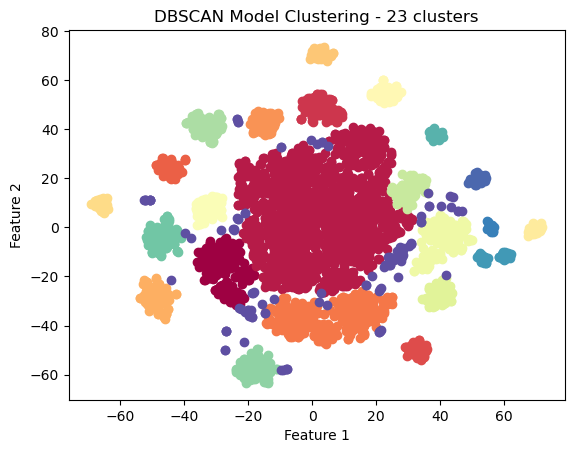

Silhouette Coefficient: 0.253


In [31]:
plot_clusters(reduced_tsne, db_labels,
              f'DBSCAN Model Clustering - {db_clusters_} clusters')
print(
    f"Silhouette Coefficient: {silhouette_score(reduced_tsne, db_labels):.3f}")

In [32]:
# OPTICS
ops = OPTICS(max_eps=5, min_samples=25, metric='euclidean')
ops_res = ops.fit(reduced_tsne)
ops_labels = ops_res.labels_
ops_clusters_ = len(set(ops_labels)) - (1 if -1 in ops_labels else 0)

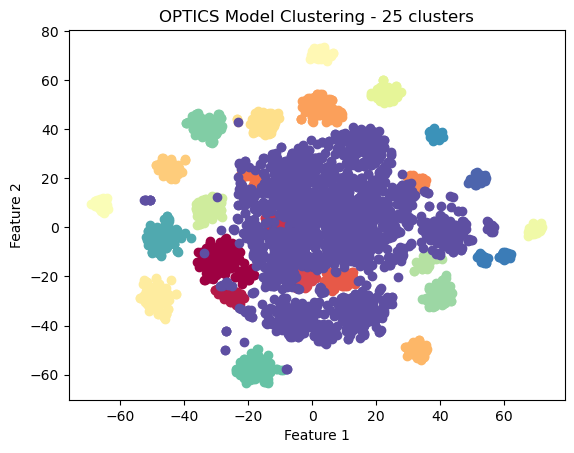

Silhouette Coefficient: -0.028


In [33]:
plot_clusters(reduced_tsne, ops_labels,
              f'OPTICS Model Clustering - {ops_clusters_} clusters')
print(
    f"Silhouette Coefficient: {silhouette_score(reduced_tsne, ops_labels):.3f}")

In [34]:
# KMeans
kmeans = KMeans(n_clusters=6, random_state=42)
kmeans_res = kmeans.fit(reduced_tsne)
kmeans_labels = kmeans_res.labels_
kmeans_clusters_ = len(np.unique(kmeans_labels))

/Users/egorgladilin/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


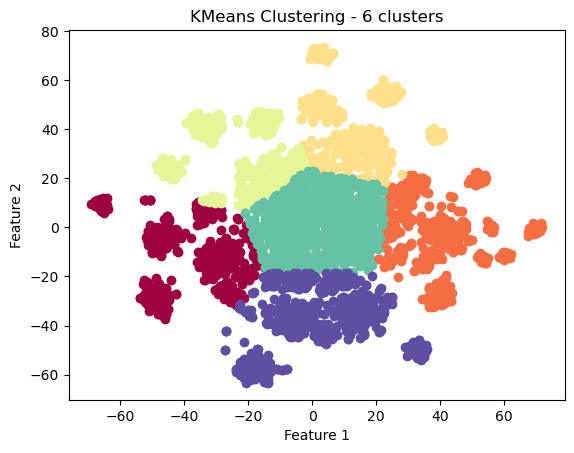

Silhouette Coefficient: 0.379


In [35]:
plot_clusters(reduced_tsne, kmeans_labels,
              f'KMeans Clustering - {kmeans_clusters_} clusters')
print(
    f"Silhouette Coefficient: {silhouette_score(reduced_tsne, kmeans_labels):.3f}")

In [36]:
# Hierarchical clustering
hier = AgglomerativeClustering(n_clusters=6)
hier_res = hier.fit(reduced_tsne)
hier_labels = hier_res.labels_
hier_clusters_ = len(np.unique(hier_labels))

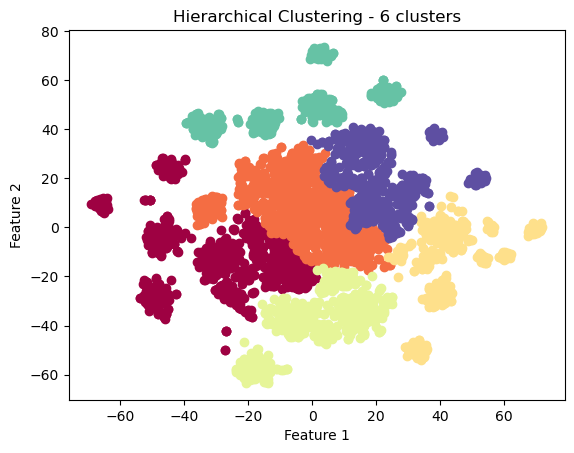

Silhouette Coefficient: 0.304


In [37]:
plot_clusters(reduced_tsne, hier_labels,
              f'Hierarchical Clustering - {hier_clusters_} clusters')
print(
    f"Silhouette Coefficient: {silhouette_score(reduced_tsne, hier_labels):.3f}")

In [38]:
birch = Birch(threshold=0.5, n_clusters=6)
birch_res = birch.fit(reduced_tsne)
birch_labels = birch_res.labels_
birch_clusters_ = len(np.unique(birch_labels))

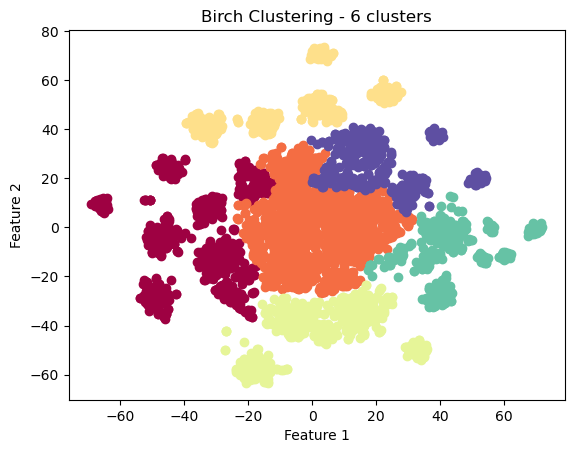

Silhouette Coefficient: 0.328


In [39]:
plot_clusters(reduced_tsne, birch_labels,
              f'Birch Clustering - {birch_clusters_} clusters')
print(
    f"Silhouette Coefficient: {silhouette_score(reduced_tsne, birch_labels):.3f}")

In [40]:
# MeanShift
meanshift = MeanShift(bandwidth=18)
meanshift_res = meanshift.fit(reduced_tsne)
meanshift_labels = meanshift_res.labels_
meanshift_clusters_ = len(np.unique(meanshift_labels))

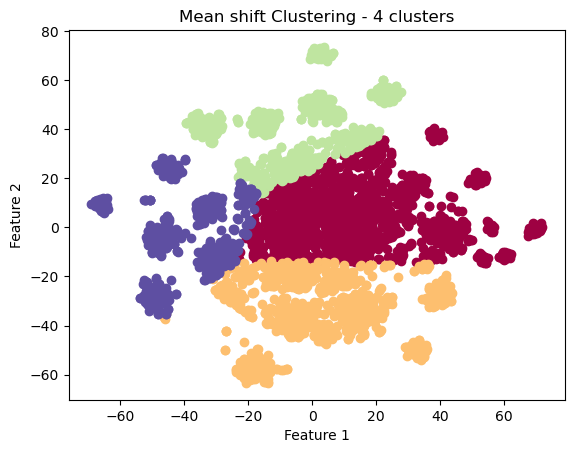

Silhouette Coefficient: 0.309


In [41]:
plot_clusters(reduced_tsne, meanshift_labels,
              f'Mean shift Clustering - {meanshift_clusters_} clusters')
print(
    f"Silhouette Coefficient: {silhouette_score(reduced_tsne, meanshift_labels):.3f}")

## elbow, davies-boulding and silhouette indexes

In [42]:
def silhouette_index(data: pd.DataFrame, num_clusters=17):
    # distortions = []
    # inertias = []
    # mapping1 = {}
    # mapping2 = {}
    K = range(2, num_clusters)
    silhouettes = []
    for k in K:
        # Building and fitting the model

        model = KMeans(n_clusters=k, random_state=42)
        model_res = model.fit(reduced_tsne)
        labels = model_res.labels_
        print(silhouette_score(reduced_tsne, labels))

        silhouettes.append(silhouette_score(data, labels))

    plt.scatter(x=[i for i in range(2, num_clusters)],
                y=silhouettes, s=150)
    plt.xlabel('Values of K')
    plt.ylabel('Number of clusters')
    plt.title('The Silhouette Index for different number of clusters')
    plt.grid(True)
    plt.axvline(6, 0, 1, label='slope change #1', color='red')
    plt.axvline(14, 0, 1, label='slope change #1', color='green')
    plt.show()

/Users/egorgladilin/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.3264744


/Users/egorgladilin/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.35237053


/Users/egorgladilin/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.3510896


/Users/egorgladilin/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.370601


/Users/egorgladilin/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.37877613


/Users/egorgladilin/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.37214988


/Users/egorgladilin/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.36164814


/Users/egorgladilin/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.36650535


/Users/egorgladilin/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.3769093


/Users/egorgladilin/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.3855968


/Users/egorgladilin/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.3852821


/Users/egorgladilin/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.39156282


/Users/egorgladilin/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.39233673


/Users/egorgladilin/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.39109132


/Users/egorgladilin/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.40680665


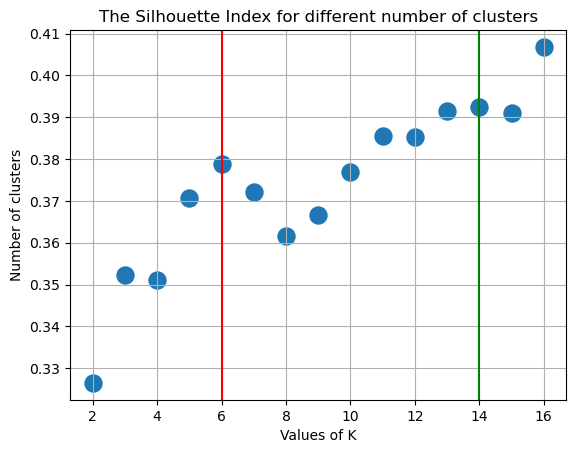

In [43]:
silhouette_index(reduced_tsne)

In [44]:
def elbow_index(data: pd.DataFrame, num_clusters=17):
    distortions = []
    inertias = []
    mapping1 = {}
    mapping2 = {}
    K = range(1, num_clusters)

    for k in K:
        # Building and fitting the model
        model = KMeans(n_clusters=k)
        model.fit(data)

        distortions.append(sum(np.min(cdist(data, model.cluster_centers_,
                                            'euclidean'), axis=1)) / data.shape[0])
        inertias.append(model.inertia_)

        mapping1[k] = sum(np.min(cdist(data, model.cluster_centers_,
                                       'euclidean'), axis=1)) / data.shape[0]
        mapping2[k] = model.inertia_

    plt.plot(K, distortions, 'bx-')
    plt.xlabel('Number of clusters')
    plt.ylabel('The Elbow Index')
    plt.title('The Elbow Index for different number of clusters')
    plt.grid(True)
    plt.show()

/Users/egorgladilin/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/egorgladilin/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/egorgladilin/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/egorgladilin/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of

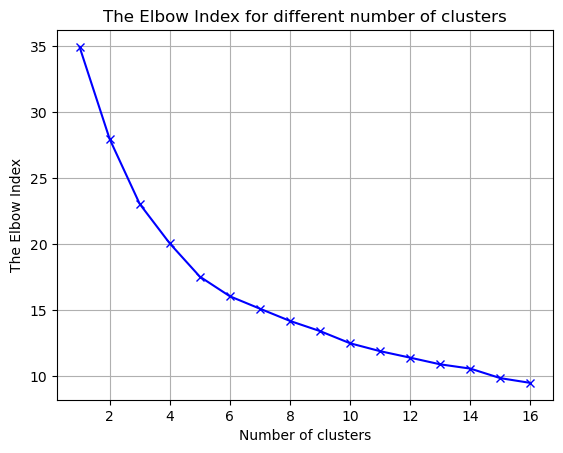

In [45]:
elbow_index(reduced_tsne)

In [46]:
def daviesboulding_index(data: pd.DataFrame, num_clusters=17):
    results_db_kmeans = {}
    for i in range(2, num_clusters):

        kmeans = KMeans(n_clusters=i)
        labels = kmeans.fit_predict(data)

        db_index = davies_bouldin_score(data, labels)
        results_db_kmeans.update({i: db_index})

    plt.style.use('seaborn')
    plt.figure(figsize=(10, 6))

    plt.plot(list(results_db_kmeans.keys()), list(results_db_kmeans.values()))

    plt.xticks(np.arange(2, num_clusters, step=1))
    plt.xlabel('Number of clusters')
    plt.ylabel('Davies-Boulding Index')
    plt.title('Davies-Boulding Index for different number of clusters')
    plt.grid(True)
    plt.axvline(3, 0, 1, label='slope change #1', color='red')
    plt.axvline(6, 0, 1, label='slope change #2', color='orange')
    plt.axvline(16, 0, 1, label='slope change #1', color='green')
    plt.show()

/Users/egorgladilin/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/egorgladilin/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/egorgladilin/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/egorgladilin/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of

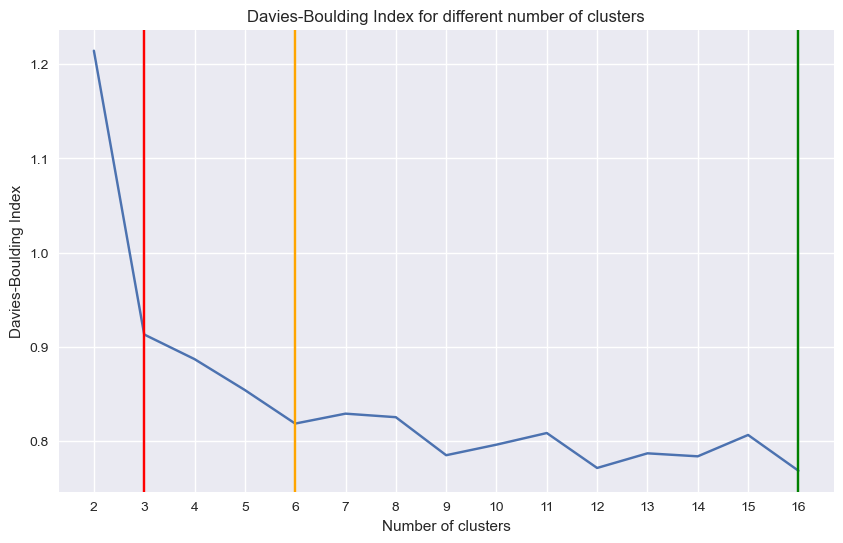

In [47]:
daviesboulding_index(reduced_tsne)

## Interpretation

In [48]:
new_data['cluster'] = kmeans_labels

/var/folders/1s/_mm_j5693hv5tyz456g5_g140000gn/T/ipykernel_31909/2260561491.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['cluster'] = kmeans_labels


In [49]:
kmeans_labels

array([0, 2, 4, ..., 1, 2, 2], dtype=int32)

In [50]:
new_data.to_csv('data_interp.csv')  # data to visualise in tableau

## RFM анализ

R (recency) - min_MnthAfterLoan <br>
F (frequency) - all_credits <br>
M (monetary) - sum_of_paym_months

In [51]:
rfm_data = new_data[['min_MnthAfterLoan', 'all_credits', 'sum_of_paym_months']]
recency = 'min_MnthAfterLoan'
frequency = 'all_credits'
monetary = 'sum_of_paym_months'

array([[<Axes: title={'center': 'min_MnthAfterLoan'}>,
        <Axes: title={'center': 'all_credits'}>],
       [<Axes: title={'center': 'sum_of_paym_months'}>, <Axes: >]],
      dtype=object)

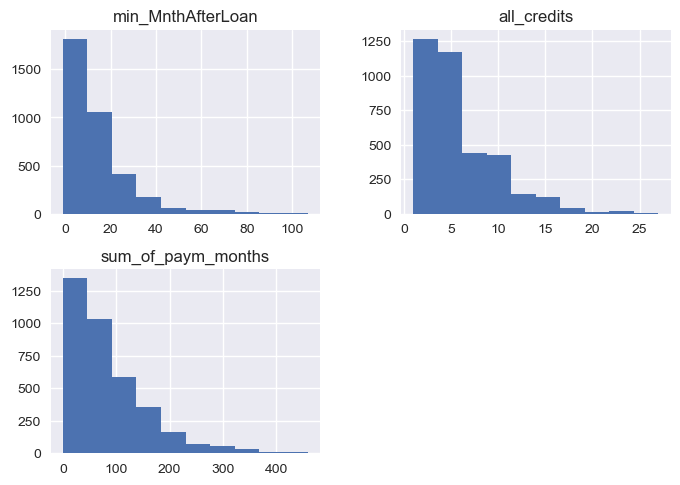

In [52]:
rfm_data.hist()

In [53]:
quantiles = rfm_data.quantile(q=[0.1, 0.25, 0.5, 0.75]).to_dict()
rfm_data.quantile(q=[0.1, 0.25, 0.5, 0.75])

,min_MnthAfterLoan,all_credits,sum_of_paym_months
0.10,2.0,2.0,13.0
0.25,4.0,3.0,31.0
0.50,10.0,5.0,64.0
0.75,18.0,8.0,118.0


In [54]:
def R_Class(x, p, d):
    if x <= d[p][0.1]:
        return 1
    elif x <= d[p][0.25]:
        return 2
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]:
        return 4
    else:
        return 5


def FM_Class(x, p, d):
    if x <= d[p][0.1]:
        return 5
    elif x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]:
        return 2
    else:
        return 1

In [55]:
copied_data = new_data_encoded.copy()

In [56]:

copied_data['SEX'] = new_data['SEX']
copied_data['EDUCATION'] = new_data['EDUCATION']
copied_data['R'] = copied_data[recency].apply(
    R_Class, args=(recency, quantiles,))
copied_data['F'] = copied_data[frequency].apply(
    FM_Class, args=(frequency, quantiles,))
copied_data['M'] = copied_data[monetary].apply(
    FM_Class, args=(monetary, quantiles,))

In [57]:
copied_data['RFM'] = 100*copied_data['R']+10*copied_data['F']+copied_data['M']

### 1st group

In [58]:
def get_group_data(group_number: int, data=copied_data):
    print('MEAN values:')
    print(data[data['R'] == group_number].mean()[[recency, frequency, monetary, 'age', 'SEX',
                                                 'EDUCATION', 'FULL_AGE_CHILD_NUMBER', 'DEPENDANT_NUMBER', 'avg_num_delay']])
    print('SUM of:')
    print(data[data['R'] == group_number].sum()[
          ['EMPL_SIZE_< 50', 'EMPL_SIZE_>250']])

    print(data[data['R'] == group_number].sum()[['CREDIT_PURPOSE_Другое', 'CREDIT_PURPOSE_Лечение',
                                                 'CREDIT_PURPOSE_Обучение', 'CREDIT_PURPOSE_Отпуск',
                                                 'CREDIT_PURPOSE_Покупка автомобиля',
                                                 'CREDIT_PURPOSE_Покупка бытовой техники',
                                                 'CREDIT_PURPOSE_Покупка земли', 'CREDIT_PURPOSE_Покупка мебели',
                                                 'CREDIT_PURPOSE_Покупка недвижимости/ строительство',
                                                 'CREDIT_PURPOSE_Ремонт']])
    print(data[data['R'] == group_number].sum()[['EMPL_TYPE_вспомогательный персонал',
                                                 'EMPL_TYPE_другое', 'EMPL_TYPE_менеджер высшего звена',
                                                 'EMPL_TYPE_менеджер по продажам', 'EMPL_TYPE_менеджер среднего звена',
                                                 'EMPL_TYPE_рабочий', 'EMPL_TYPE_специалист',
                                                 'EMPL_TYPE_страховой агент', 'EMPL_TYPE_торговый представитель',]])

In [59]:
get_group_data(2)

MEAN values:
min_MnthAfterLoan         3.466184
all_credits               6.956522
sum_of_paym_months       86.099034
age                      35.712560
SEX                       0.526570
EDUCATION                 4.789855
FULL_AGE_CHILD_NUMBER     0.572464
DEPENDANT_NUMBER          0.000000
avg_num_delay             0.052340
dtype: float64
SUM of:
EMPL_SIZE_< 50     86.0
EMPL_SIZE_>250    328.0
dtype: float64
CREDIT_PURPOSE_Другое                                   7.0
CREDIT_PURPOSE_Лечение                                  6.0
CREDIT_PURPOSE_Обучение                                12.0
CREDIT_PURPOSE_Отпуск                                  12.0
CREDIT_PURPOSE_Покупка автомобиля                      70.0
CREDIT_PURPOSE_Покупка бытовой техники                  5.0
CREDIT_PURPOSE_Покупка земли                            4.0
CREDIT_PURPOSE_Покупка мебели                           6.0
CREDIT_PURPOSE_Покупка недвижимости/ строительство     55.0
CREDIT_PURPOSE_Ремонт                         

In [60]:
copied_data[copied_data['R'] == 1][['R', 'F', 'M']].groupby(['F', 'M']).count()

R
F M     
1 1  125
  2   49
  3   10
  4    1
  5    1
2 1   27
  2   60
  3   48
  4    5
3 1    4
  2   23
  3   45
  4   17
  5    4
4 2    3
  3   15
  4   14
  5   14
5 2    1
  3    3
  4    9
  5   47

### 2nd group

In [61]:
get_group_data(2)

MEAN values:
min_MnthAfterLoan         3.466184
all_credits               6.956522
sum_of_paym_months       86.099034
age                      35.712560
SEX                       0.526570
EDUCATION                 4.789855
FULL_AGE_CHILD_NUMBER     0.572464
DEPENDANT_NUMBER          0.000000
avg_num_delay             0.052340
dtype: float64
SUM of:
EMPL_SIZE_< 50     86.0
EMPL_SIZE_>250    328.0
dtype: float64
CREDIT_PURPOSE_Другое                                   7.0
CREDIT_PURPOSE_Лечение                                  6.0
CREDIT_PURPOSE_Обучение                                12.0
CREDIT_PURPOSE_Отпуск                                  12.0
CREDIT_PURPOSE_Покупка автомобиля                      70.0
CREDIT_PURPOSE_Покупка бытовой техники                  5.0
CREDIT_PURPOSE_Покупка земли                            4.0
CREDIT_PURPOSE_Покупка мебели                           6.0
CREDIT_PURPOSE_Покупка недвижимости/ строительство     55.0
CREDIT_PURPOSE_Ремонт                         

In [62]:
copied_data[copied_data['R'] == 2][['R', 'F', 'M']].groupby(['F', 'M']).count()

R
F M    
1 1  86
  2  34
  3   2
  4   1
2 1  18
  2  50
  3  29
  4   2
3 1   9
  2  14
  3  45
  4  30
  5   2
4 3  18
  4  26
  5   8
5 2   1
  3   1
  4   8
  5  30

### 3rd groupd

In [63]:
get_group_data(3)

MEAN values:
min_MnthAfterLoan         7.184925
all_credits               6.437186
sum_of_paym_months       86.467337
age                      35.250251
SEX                       0.525628
EDUCATION                 4.735678
FULL_AGE_CHILD_NUMBER     0.475377
DEPENDANT_NUMBER          0.002010
avg_num_delay             0.054493
dtype: float64
SUM of:
EMPL_SIZE_< 50    220.0
EMPL_SIZE_>250    775.0
dtype: float64
CREDIT_PURPOSE_Другое                                  47.0
CREDIT_PURPOSE_Лечение                                 11.0
CREDIT_PURPOSE_Обучение                                14.0
CREDIT_PURPOSE_Отпуск                                  48.0
CREDIT_PURPOSE_Покупка автомобиля                     176.0
CREDIT_PURPOSE_Покупка бытовой техники                 17.0
CREDIT_PURPOSE_Покупка земли                           18.0
CREDIT_PURPOSE_Покупка мебели                          17.0
CREDIT_PURPOSE_Покупка недвижимости/ строительство     91.0
CREDIT_PURPOSE_Ремонт                         

In [64]:
copied_data[copied_data['R'] == 3][['R', 'F', 'M']].groupby(['F', 'M']).count()

R
F M     
1 1  188
  2   55
  3    9
  5    1
2 1   64
  2  115
  3   62
  4    3
3 1   16
  2   56
  3  118
  4   47
  5    1
4 2   13
  3   43
  4   43
  5    5
5 3    7
  4   43
  5  106

### 4th grouod

In [65]:
get_group_data(4)

MEAN values:
min_MnthAfterLoan        13.840244
all_credits               5.467073
sum_of_paym_months       84.425610
age                      36.074390
SEX                       0.475610
EDUCATION                 4.706098
FULL_AGE_CHILD_NUMBER     0.565854
DEPENDANT_NUMBER          0.004878
avg_num_delay             0.056307
dtype: float64
SUM of:
EMPL_SIZE_< 50    201.0
EMPL_SIZE_>250    619.0
dtype: float64
CREDIT_PURPOSE_Другое                                  37.0
CREDIT_PURPOSE_Лечение                                  3.0
CREDIT_PURPOSE_Обучение                                10.0
CREDIT_PURPOSE_Отпуск                                  27.0
CREDIT_PURPOSE_Покупка автомобиля                     152.0
CREDIT_PURPOSE_Покупка бытовой техники                 10.0
CREDIT_PURPOSE_Покупка земли                           12.0
CREDIT_PURPOSE_Покупка мебели                          15.0
CREDIT_PURPOSE_Покупка недвижимости/ строительство    117.0
CREDIT_PURPOSE_Ремонт                         

In [66]:
copied_data[copied_data['R'] == 4][['R', 'F', 'M']].groupby(['F', 'M']).count()

R
F M     
1 1  113
  2   26
  3    3
2 1   62
  2   91
  3   34
  4    2
3 1   18
  2   79
  3   82
  4   17
  5    1
4 1    3
  2   17
  3   69
  4   21
5 2    3
  3   24
  4   89
  5   66

### 5th group

In [67]:
get_group_data(5)

MEAN values:
min_MnthAfterLoan        34.686188
all_credits               3.750276
sum_of_paym_months       73.533702
age                      37.293923
SEX                       0.451934
EDUCATION                 4.731492
FULL_AGE_CHILD_NUMBER     0.548066
DEPENDANT_NUMBER          0.004420
avg_num_delay             0.064959
dtype: float64
SUM of:
EMPL_SIZE_< 50    242.0
EMPL_SIZE_>250    663.0
dtype: float64
CREDIT_PURPOSE_Другое                                  34.0
CREDIT_PURPOSE_Лечение                                 12.0
CREDIT_PURPOSE_Обучение                                10.0
CREDIT_PURPOSE_Отпуск                                  35.0
CREDIT_PURPOSE_Покупка автомобиля                     156.0
CREDIT_PURPOSE_Покупка бытовой техники                 10.0
CREDIT_PURPOSE_Покупка земли                            7.0
CREDIT_PURPOSE_Покупка мебели                          17.0
CREDIT_PURPOSE_Покупка недвижимости/ строительство    132.0
CREDIT_PURPOSE_Ремонт                         

In [68]:
copied_data[copied_data['R'] == 5][['R', 'F', 'M']].groupby(['F', 'M']).count()

R
F M     
1 1   61
  2    8
  3    1
2 1   52
  2   43
  3   12
3 1   44
  2   85
  3   65
  4   15
4 1   10
  2   41
  3   60
  4   32
  5    3
5 1    2
  2   42
  3  108
  4  127
  5   94